In [1]:
import torch
import torchvision
import time
import random
import math
import json

from PIL import Image, ImageDraw, ImageFont
from typing import Callable

device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
def displayCoords(image, coords, labels):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for i in range(len(coords)):
        coord = coords[i]
        label = labels[i]
        x1 = coord[0]
        y1 = coord[1]
        x2 = coord[2]
        y2 = coord[3]
        val = label/26
        r = math.floor(-val*255)%256
        g = math.floor(val*255)%256
        b = math.floor(-val*255)%256
        
        draw.rectangle([x1,y1,x2,y2], outline=(r,g,b), width=2)
        draw.text((x1,y1-25), alphabet[label], (r,g,b), font=font)
        
    display(imageCopy)

In [3]:
class imageLoader():
    def __init__(self, list_images_info, batch_size):
        self.resetNeeded = False
        self.selector_index = 0
        self.list_images_info = []
        self.batch_size = batch_size
        self.index_list = [i for i in range(len(list_images_info))]
        random.shuffle(self.index_list)
        self.to_tensor = torchvision.transforms.ToTensor()
        
        
        for i in range(len(list_images_info)):
            self.list_images_info.append({
                'boxes' : torch.FloatTensor(list_images_info[i]['boxes']), 
                'labels' : torch.LongTensor(list_images_info[i]['labels']), 
                'image' : list_images_info[i]['image']}
            )
        
    def needsReset(self)->bool:
        return self.resetNeeded
    
    def reset(self):
        self.selector_index = 0
        random.shuffle(self.index_list)
        self.resetNeeded = False
    
    def getIndexValue(self) -> int:
        return self.selector_index
    
    def getSelectedRandomIndex(self) -> int:
        return self.index_list[self.selector_index]

    def getNextBatch(self):
        true_list_len = len(self.index_list)
        selected_index = -1
        list_len = true_list_len - self.selector_index
        
        selected_indices = []
        while len(selected_indices) < self.batch_size:
            list_len = true_list_len - self.selector_index
            n_to_find = self.batch_size - len(selected_indices)
            start = self.selector_index

            if list_len > n_to_find:
                end = self.selector_index + n_to_find
                selected_indices.extend(self.index_list[start:end])
                self.selector_index += n_to_find
            else:
                self.resetNeeded = True
                selected_indices.extend(self.index_list[start:])
                random.shuffle(self.index_list)
                self.selector_index = 0
        
        list_infos = [{
                        'boxes':self.list_images_info[index]['boxes'].to(device=device),
                        'labels':self.list_images_info[index]['labels'].to(device=device)
        }for index in selected_indices]
                        
        
        start=time.time() #debug
        images = [Image.open(self.list_images_info[index]['image']) for index in selected_indices]
        images = [self.to_tensor(image).to(device=device) for image in images]
        #images = torch.stack(images, dim=0) #Not necessary for FASTERRCNN_RESNET50_FPN
        end=time.time() #debug
        #timeSelectionDataset+=end-start  #debug
        
        
        """
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            labels = self.target_transform(labels)
        """
        
        return images, list_infos
        

In [4]:
def train(model, n_epoch, batch_size, lr: Callable[[int], float], images_infos: list):
    
    global timeSelectionDataset
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr(0))
    
    train_separator = int(len(images_infos)*0.7)
    print(train_separator)
    custom_loader_train = imageLoader(images_infos[:train_separator], batch_size=batch_size)
    custom_loader_eval = imageLoader(images_infos[train_separator+1:], batch_size=batch_size)
    
    frequency_detailed_results = 5
    
    model_info = model.train()
    
    best_percent = 0
    for epoch in range(n_epoch):
        
        n_correct_1_t = 0
        n_correct_5_t = 0
        n_correct_1_e = 0
        n_correct_5_e = 0
        
        n_total = 0
        t_loss_rpn_pos = 0
        t_loss_rpn_interest = 0
        t_loss_cnn_pos = 0
        t_loss_cnn_class = 0
        
        for g in optimizer.param_groups:
            g['lr'] = lr(epoch)
            
        time_select = 0 #debug
        time_model = 0 #debug
        timeSelectionDataset = 0 # debug
        start_epoch = time.time() #debug
            
        print("Epoch " + str(epoch+1))
        custom_loader_train.reset()
        index = 0
        while not custom_loader_train.needsReset():
            print(index, end=' ')
            index+=1
            
            model.zero_grad()
            #optimizer.zero_grad() not needed ?
            
            start = time.time() #debug
            images, info_batch = custom_loader_train.getNextBatch()
            end = time.time() #debug
            time_select = end-start # debug
            #print(str(index)+" : Selection time -> " + str(time_select))
            
            start = time.time() #debug
            losses = model(images,info_batch)
            end = time.time() #debug
            time_model = end-start # debug
            #print(str(index)+" : Model time -> " + str(time_model))
            
            t_loss_rpn_pos += losses['loss_rpn_box_reg'].item()
            t_loss_rpn_interest += losses['loss_objectness'].item()
            t_loss_cnn_pos += losses['loss_box_reg'].item()
            t_loss_cnn_class += losses['loss_classifier'].item()
            
            start = time.time() #debug
            losses['loss_rpn_box_reg'].backward(retain_graph=True)
            losses['loss_objectness'].backward(retain_graph=True)
            losses['loss_box_reg'].backward(retain_graph=True)
            losses['loss_classifier'].backward()
            optimizer.step() #Trying at the end of the epoch ?
            end = time.time() #debug
            time_backward = end-start # debug
            #print(str(index)+" : Backward time -> " + str(time_backward))
            
            
            n_total += batch_size
            """
            if (epoch+1) % frequency_detailed_results == 0:
                model.eval()
                images_eval, info_eval = custom_loader_eval.getNextBatch()
                losses_eval = model(images_eval)
                
                n_correct_1_t += countCorrect(answer, labels.to(device=device))
                n_correct_5_t += countTop5Correct(answer, labels.to(device=device))
                n_correct_1_e += countCorrect(answer_eval, labels_eval.to(device=device))
                n_correct_5_e += countTop5Correct(answer_eval, labels_eval.to(device=device))
            """
        print("")
        adjust = 100
        #percent_1_t = math.floor(adjust*100*n_correct_1_t/n_total)/adjust
        #percent_5_t = math.floor(adjust*100*n_correct_5_t/n_total)/adjust
        #percent_1_e = math.floor(adjust*100*n_correct_1_e/n_total)/adjust
        #percent_5_e = math.floor(adjust*100*n_correct_5_e/n_total)/adjust
        
        #display_loss = math.floor(adjust*t_loss)/adjust
        
        #best_percent = percent_5_e if percent_5_e > best_percent else best_percent
        
        end_epoch = time.time()
        time_epoch = end_epoch-start_epoch
        
        
        timeSelection=0
        print("Time epoch : " + str(math.floor(time_epoch*adjust)/adjust) + "s") #debug
        
        #print("\tTime select : " + str(math.floor(time_select*adjust)/adjust)) #debug
        #print("\t - Time select (inside) : " + str(math.floor(timeSelectionDataset*adjust)/adjust)) #debug
        #print("\tTime model : " + str(math.floor(time_model*adjust)/adjust)) #debug
        
        
        timer1 = 0
        timer2 = 0
        timer3 = 0
        
        print("\tloss_rpn_pos : {0:.2f}".format(t_loss_rpn_pos))
        print("\tloss_rpn_interest : {0:.2f}".format(t_loss_rpn_interest))
        print("\tloss_cnn_pos : {0:.2f}".format(t_loss_cnn_pos))
        print("\tloss_cnn_class : {0:.2f}".format(t_loss_cnn_class))
        #print("\tLoss : " + str(display_loss))
        
        """
        if (epoch+1) % frequency_detailed_results == 0:
            print("\tTop-1 training accuracy : " + str(percent_1_t) + "%")
            print("\tTop-5 training accuracy : " + str(percent_5_t) + "%")
            print("\tTop-1 evaluation accuracy : " + str(percent_1_e) + "%")
            print("\tTop-5 evaluation accuracy : " + str(percent_5_e) + "%")
        """
        #if percent_5_e > 99.0:
            #break
        
        print("")
        
    return best_percent

In [5]:
#trainModel = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
trainModel = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=None,
    num_classes=26,
    box_detections_per_img=100
)
n_epochs = 30

lr: Callable[[int], float] = lambda epoch: 0.0003/(1.03**epoch)

with open('targets.json', 'r', encoding="utf-8") as f:
    infos = json.load(f)
    #train(trainModel, n_epochs, batch_sizes[0], learning_rates[0])
    print("Running on " + device + "\n")
    percent = train(trainModel.to(device=device), n_epochs, 10, lr, infos)

Running on cuda

700
Epoch 1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 
Time epoch : 22.17s
	loss_rpn_pos : 1.95
	loss_rpn_interest : 10.23
	loss_cnn_pos : 26.30
	loss_cnn_class : 49.56

Epoch 2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 
Time epoch : 16.9s
	loss_rpn_pos : 1.18
	loss_rpn_interest : 2.32
	loss_cnn_pos : 48.89
	loss_cnn_class : 40.84

Epoch 3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 
Time epoch : 15.25s
	loss_rpn_pos : 0.84
	loss_rpn_interest : 1.94
	loss_cnn_pos : 53.52
	loss_cnn_class : 30.89

Epoch 4
0 

In [6]:
trainModel.eval()

torch.save(trainModel.cpu(),'./Models/SoulGlyph_Mobile_Model_V1.pt')

torch.save(trainModel.cpu().state_dict(), './Models/SoulGlyph_Mobile_Model_V1.pth')


In [8]:
#evalModel = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
evalModel = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=None,
    num_classes=26,
    box_detections_per_img=100
)
evalModel.eval()
evalModel.load_state_dict(torch.load("./Models/SoulGlyph_Mobile_Model_V1.pth"))

<All keys matched successfully>

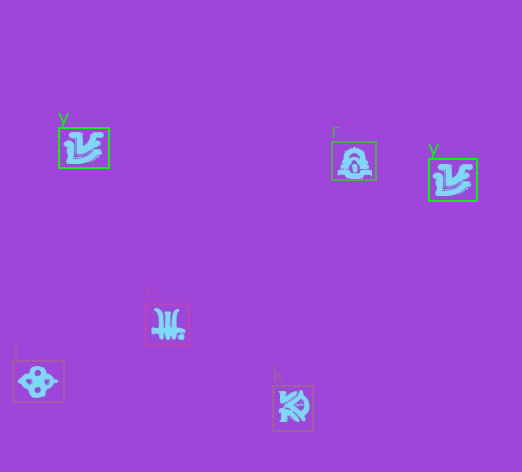

tensor([[ 58.7971, 127.0269, 109.1283, 168.6738],
        [272.7720, 385.4902, 313.3066, 431.4581],
        [ 12.1116, 360.9046,  64.0238, 402.1376],
        [331.0537, 141.2444, 376.5564, 180.4524],
        [145.8069, 303.0657, 189.4250, 345.8220],
        [428.2021, 158.6051, 477.5408, 201.0352]], grad_fn=<StackBackward0>)
tensor([24, 10,  9, 17,  7, 24])
tensor([0.9992, 0.9989, 0.9986, 0.9985, 0.9984, 0.9979],
       grad_fn=<IndexBackward0>)


In [25]:
with open('targets.json', 'r', encoding="utf-8") as f:
    image_nb = 107
    infos = json.load(f)
    test_img = Image.open(infos[image_nb]['image'])
    to_tensor = torchvision.transforms.ToTensor()
    test_tensor = to_tensor(test_img)
    result = evalModel([test_tensor])
    displayCoords(test_img, result[0]['boxes'].tolist(), result[0]['labels'].tolist())
    print(result[0]['boxes'])
    print(result[0]['labels'])
    print(result[0]['scores'])